In [1]:
import sqlite3
from typing import Any, Optional
from pydantic import BaseModel, Extra, Field
from transformers import TrainingArguments, AutoModel, AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
import numpy as np
import json
import datasets
import wandb
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import sys
sys.path.append('../../')
sys.path.append('./set_transformer/')
from subset_active_learning.subset_selection import select, preprocess
from subset_active_learning.active_learning.subset_classifier import get_df_from_db

import torch.nn as nn
from modules import SAB, PMA

2022-10-21 02:26:50.923824: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2022-10-21 02:26:50.923865: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
model_path = './deepset_genetic.pt'
db_path = "./genetic_deepset_search.db"
seed = 0
pool_size = 1000
search_size = 100
warmup_runs = 500
annealing_runs = 100
wandb_project = 'sst_subset_search'
wandb_entity = 'johntzwei'

In [3]:
searching_args = select.SubsetSearcherArguments(db_path=db_path,
                                                seed=seed,
                                                data_pool_size=pool_size,
                                                optimal_subset_size=search_size,
                                                warmup_runs=warmup_runs,
                                                annealing_runs=annealing_runs,
                                                wandb_project=wandb_project,
                                                wandb_entity=wandb_entity
                                               )

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [5]:
class DeepSet(nn.Module):
    def __init__(self, embedding, embedding_dim, enc_num_layers, enc_dim, enc_num_heads, dec_dim, dec_num_heads):
        super().__init__()
        
        dropout_p = 0.2
        
        self.enc = nn.Sequential(
            embedding,
            nn.Linear(in_features=embedding_dim, out_features=enc_dim),
            torch.nn.Dropout(dropout_p),
            nn.ReLU(),
            nn.Linear(in_features=enc_dim, out_features=enc_dim),
            torch.nn.Dropout(dropout_p),
            nn.ReLU(),
            nn.Linear(in_features=enc_dim, out_features=enc_dim),
            torch.nn.Dropout(dropout_p),
            nn.ReLU(),
        )
            
        self.dec = nn.Sequential(
            nn.Linear(in_features=enc_dim, out_features=dec_dim),
            torch.nn.Dropout(dropout_p),
            nn.ReLU(),
            nn.Linear(in_features=dec_dim, out_features=dec_dim),
            torch.nn.Dropout(dropout_p),
            nn.ReLU(),
            nn.Linear(in_features=dec_dim, out_features=1),
        )

    def forward(self, x):
        x = self.enc(x)
        x = torch.mean(x, axis=-2)
        x = self.dec(x)
        return x.squeeze(-1)

In [6]:
class DeepsetSearcher(select.GeneticSearcher):
    def one_run(self):
        # seed_everything(self.seed)
        current_num_run = self._get_num_runs()
        new_subset_indices = self.select_new_subset(current_num_run)
        new_quality = self.train_one_step(new_subset_indices)
        print(new_quality)
        self._insert_run(subset_indices=new_subset_indices, quality=new_quality)

    def train_one_step(self, new_subset):
        inp = torch.LongTensor([new_subset])
        inp = inp.to(device)
        model.eval()
        output = model(inp)
        return output.item()

In [7]:
emb_type = 'trained'

if emb_type == 'scratch':
    embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
elif emb_type == 'trained':
    to_shuffle_mapping = np.load('./shuffled_idx.npy')
    numpy_embeddings = torch.load('./trained-emb_train.pt')
    downsample_embeddings = numpy_embeddings[to_shuffle_mapping][1000:]
    embedding = torch.nn.Embedding.from_pretrained(torch.Tensor(downsample_embeddings))
    embedding.requires_grad = False
elif emb_type == 'infersent':
    to_shuffle_mapping = np.load('./shuffled_idx.npy')
    numpy_embeddings = np.load('./infersent-emb_train.npy')
    downsample_embeddings = numpy_embeddings[to_shuffle_mapping][1000:]     # NEEDS TO BE MAPPED for next 1k sents
    embedding = torch.nn.Embedding.from_pretrained(torch.Tensor(downsample_embeddings))
    embedding.requires_grad = False

In [8]:
model = torch.load(model_path)
model.enc[0] = embedding
model.to(device)

DeepSet(
  (enc): Sequential(
    (0): Embedding(7544, 768)
    (1): Linear(in_features=768, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=2048, bias=True)
    (4): ReLU()
    (5): Linear(in_features=2048, out_features=2048, bias=True)
    (6): ReLU()
  )
  (dec): Sequential(
    (0): Linear(in_features=2048, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=1, bias=True)
  )
)

/home/johnny/.conda/envs/torch/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

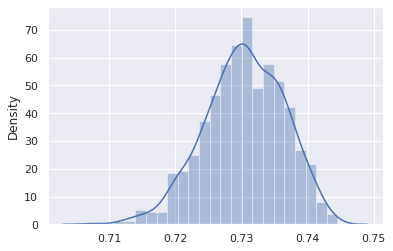

In [9]:
predictions = []
for i in range(0, 1000):
    pool_idx = np.arange(pool_size)
    search_idx = np.random.choice(pool_idx, size=search_size)
    
    inp = torch.LongTensor([search_idx])
    inp = inp.to(device)
    output = model(inp)
    model.eval()
    
    pred_acc = output.item()
    predictions.append(pred_acc)

sns.distplot(predictions)

In [10]:
subset_trainer = DeepsetSearcher(
    data_pool=np.arange(1000), subset_trainer=None, params=searching_args
)

In [14]:
subset_trainer.search(3000)

### RUN 0
0.7614700794219971
### RUN 1
0.7558946013450623
### RUN 2
0.7609988451004028
### RUN 3
0.7623509168624878
### RUN 4
0.7617163062095642
### RUN 5
0.7600117325782776
### RUN 6
0.7627912163734436
### RUN 7
0.7602860331535339
### RUN 8
0.7570451498031616
### RUN 9
0.7615376710891724
### RUN 10
0.7654393911361694
### RUN 11
0.760373592376709
### RUN 12
0.7608729600906372
### RUN 13
0.7622697949409485
### RUN 14
0.7590355277061462
### RUN 15
0.7608131170272827
### RUN 16
0.7639368176460266
### RUN 17
0.7587443590164185
### RUN 18
0.7627333998680115
### RUN 19
0.7653563022613525
### RUN 20
0.7597544193267822
### RUN 21
0.7648645043373108
### RUN 22
0.7610659003257751
### RUN 23
0.7603990435600281
### RUN 24
0.7615966796875
### RUN 25
0.7626159191131592
### RUN 26
0.759347677230835
### RUN 27
0.760728120803833
### RUN 28
0.7626431584358215
### RUN 29
0.7551722526550293
### RUN 30
0.761489987373352
### RUN 31
0.764575719833374
### RUN 32
0.7585552930831909
### RUN 33
0.761943638324737

0.7621040344238281
### RUN 275
0.7629421353340149
### RUN 276
0.7621291279792786
### RUN 277
0.7626409530639648
### RUN 278
0.7633658051490784
### RUN 279
0.761002779006958
### RUN 280
0.7613778114318848
### RUN 281
0.7643629312515259
### RUN 282
0.7622306942939758
### RUN 283
0.7646015286445618
### RUN 284
0.7660837769508362
### RUN 285
0.7646912336349487
### RUN 286
0.7628434896469116
### RUN 287
0.7612382769584656
### RUN 288
0.7638918161392212
### RUN 289
0.7642337679862976
### RUN 290
0.7592374086380005
### RUN 291
0.7620260715484619
### RUN 292
0.7630459070205688
### RUN 293
0.7619548439979553
### RUN 294
0.7656283378601074
### RUN 295
0.7623066902160645
### RUN 296
0.7637573480606079
### RUN 297
0.7649483680725098
### RUN 298
0.7625080347061157
### RUN 299
0.7611145973205566
### RUN 300
0.7653529047966003
### RUN 301
0.7613857984542847
### RUN 302
0.7623122334480286
### RUN 303
0.7590993642807007
### RUN 304
0.763434886932373
### RUN 305
0.7634313106536865
### RUN 306
0.76392376

0.7638575434684753
### RUN 545
0.7650063037872314
### RUN 546
0.7649812698364258
### RUN 547
0.7631295919418335
### RUN 548
0.7624789476394653
### RUN 549
0.7613780498504639
### RUN 550
0.7611353993415833
### RUN 551
0.764200747013092
### RUN 552
0.761669397354126
### RUN 553
0.7644907832145691
### RUN 554
0.757562518119812
### RUN 555
0.762462317943573
### RUN 556
0.7638533115386963
### RUN 557
0.7608112096786499
### RUN 558
0.7640547156333923
### RUN 559
0.7604998350143433
### RUN 560
0.7637987732887268
### RUN 561
0.7609280347824097
### RUN 562
0.7640572786331177
### RUN 563
0.7592928409576416
### RUN 564
0.7630935907363892
### RUN 565
0.7646036148071289
### RUN 566
0.7648324966430664
### RUN 567
0.7628483772277832
### RUN 568
0.7638688683509827
### RUN 569
0.7629047632217407
### RUN 570
0.762849748134613
### RUN 571
0.7612573504447937
### RUN 572
0.7631774544715881
### RUN 573
0.7584953308105469
### RUN 574
0.7636641263961792
### RUN 575
0.7628846168518066
### RUN 576
0.76385253667

0.7652275562286377
### RUN 816
0.7635509371757507
### RUN 817
0.7612287998199463
### RUN 818
0.7610865235328674
### RUN 819
0.7621775269508362
### RUN 820
0.7682766318321228
### RUN 821
0.7650258541107178
### RUN 822
0.7636728286743164
### RUN 823
0.7656526565551758
### RUN 824
0.7654893398284912
### RUN 825
0.7647712826728821
### RUN 826
0.7648138403892517
### RUN 827
0.7574548125267029
### RUN 828
0.7652584910392761
### RUN 829
0.762226939201355
### RUN 830
0.7634406089782715
### RUN 831
0.7615770697593689
### RUN 832
0.762871265411377
### RUN 833
0.7636674642562866
### RUN 834
0.7650957703590393
### RUN 835
0.7660752534866333
### RUN 836
0.7658923864364624
### RUN 837
0.7656669020652771
### RUN 838
0.7634516358375549
### RUN 839
0.7641318440437317
### RUN 840
0.7628511190414429
### RUN 841
0.7593538165092468
### RUN 842
0.7619852423667908
### RUN 843
0.7652869820594788
### RUN 844
0.7672596573829651
### RUN 845
0.7611124515533447
### RUN 846
0.7646586298942566
### RUN 847
0.76568859

0.7645573616027832
### RUN 1081
0.7636651992797852
### RUN 1082
0.7623177170753479
### RUN 1083
0.7629815936088562
### RUN 1084
0.7658134698867798
### RUN 1085
0.7641096711158752
### RUN 1086
0.7636449337005615
### RUN 1087
0.761692225933075
### RUN 1088
0.7653387188911438
### RUN 1089
0.7622774243354797
### RUN 1090
0.7652592658996582
### RUN 1091
0.7653526067733765
### RUN 1092
0.7646665573120117
### RUN 1093
0.7670663595199585
### RUN 1094
0.7581543326377869
### RUN 1095
0.7668887972831726
### RUN 1096
0.7650726437568665
### RUN 1097
0.7649194002151489
### RUN 1098
0.7636777758598328
### RUN 1099
0.7665331959724426
### RUN 1100
0.7632285952568054
### RUN 1101
0.7689110040664673
### RUN 1102
0.7658836841583252
### RUN 1103
0.766942024230957
### RUN 1104
0.7651523947715759
### RUN 1105
0.7663229703903198
### RUN 1106
0.7605280876159668
### RUN 1107
0.7654429078102112
### RUN 1108
0.7639651298522949
### RUN 1109
0.7610763907432556
### RUN 1110
0.7644714713096619
### RUN 1111
0.75841188

0.7670570611953735
### RUN 1343
0.7640968561172485
### RUN 1344
0.7666475176811218
### RUN 1345
0.7639060020446777
### RUN 1346
0.76604825258255
### RUN 1347
0.7659417986869812
### RUN 1348
0.7682145237922668
### RUN 1349
0.7655979990959167
### RUN 1350
0.763484537601471
### RUN 1351
0.7669461369514465
### RUN 1352
0.7565892934799194
### RUN 1353
0.7674208879470825
### RUN 1354
0.7636083960533142
### RUN 1355
0.7653480768203735
### RUN 1356
0.766463041305542
### RUN 1357
0.7640008926391602
### RUN 1358
0.7663956880569458
### RUN 1359
0.7686876654624939
### RUN 1360
0.7681168913841248
### RUN 1361
0.7625614404678345
### RUN 1362
0.7654408812522888
### RUN 1363
0.7677050232887268
### RUN 1364
0.7663475871086121
### RUN 1365
0.7653810977935791
### RUN 1366
0.7624620199203491
### RUN 1367
0.7657865285873413
### RUN 1368
0.7642279863357544
### RUN 1369
0.7709016799926758
### RUN 1370
0.7665843963623047
### RUN 1371
0.7601543664932251
### RUN 1372
0.7650543451309204
### RUN 1373
0.7638091444

### RUN 1601
0.7696183323860168
### RUN 1602
0.7676860690116882
### RUN 1603
0.7693296074867249
### RUN 1604
0.764376699924469
### RUN 1605
0.75983726978302
### RUN 1606
0.7660483121871948
### RUN 1607
0.7672997713088989
### RUN 1608
0.765971302986145
### RUN 1609
0.7678390145301819
### RUN 1610
0.768227219581604
### RUN 1611
0.7644361257553101
### RUN 1612
0.7674289345741272
### RUN 1613
0.7639792561531067
### RUN 1614
0.7655051350593567
### RUN 1615
0.7681550979614258
### RUN 1616
0.7669073939323425
### RUN 1617
0.7628523707389832
### RUN 1618
0.7613088488578796
### RUN 1619
0.7656124830245972
### RUN 1620
0.7669886946678162
### RUN 1621
0.7691487073898315
### RUN 1622
0.768578827381134
### RUN 1623
0.7653995752334595
### RUN 1624
0.7659311294555664
### RUN 1625
0.7640320062637329
### RUN 1626
0.7601805329322815
### RUN 1627
0.7668165564537048
### RUN 1628
0.7660413384437561
### RUN 1629
0.7626033425331116
### RUN 1630
0.7680287957191467
### RUN 1631
0.7671152353286743
### RUN 1632
0

0.7638245224952698
### RUN 1863
0.7577453255653381
### RUN 1864
0.7639583945274353
### RUN 1865
0.7650529742240906
### RUN 1866
0.7672028541564941
### RUN 1867
0.7603524327278137
### RUN 1868
0.766690194606781
### RUN 1869
0.7678933143615723
### RUN 1870
0.7654452323913574
### RUN 1871
0.7627461552619934
### RUN 1872
0.7671539783477783
### RUN 1873
0.7680059671401978
### RUN 1874
0.7670826315879822
### RUN 1875
0.7526599764823914
### RUN 1876
0.7646349668502808
### RUN 1877
0.7690725922584534
### RUN 1878
0.7665268182754517
### RUN 1879
0.7624984383583069
### RUN 1880
0.7659334540367126
### RUN 1881
0.7646419405937195
### RUN 1882
0.7636526226997375
### RUN 1883
0.7649145126342773
### RUN 1884
0.7635055184364319
### RUN 1885
0.7651746273040771
### RUN 1886
0.7662488222122192
### RUN 1887
0.7671270966529846
### RUN 1888
0.7664617896080017
### RUN 1889
0.7698245048522949
### RUN 1890
0.7618651986122131
### RUN 1891
0.7668069005012512
### RUN 1892
0.767892599105835
### RUN 1893
0.76813024

### RUN 2123
0.7679128050804138
### RUN 2124
0.7652589082717896
### RUN 2125
0.7681198716163635
### RUN 2126
0.7580169439315796
### RUN 2127
0.7658167481422424
### RUN 2128
0.767615020275116
### RUN 2129
0.7697550058364868
### RUN 2130
0.7603013515472412
### RUN 2131
0.7649946808815002
### RUN 2132
0.7673385143280029
### RUN 2133
0.7681569457054138
### RUN 2134
0.7600952386856079
### RUN 2135
0.7652578949928284
### RUN 2136
0.7663505673408508
### RUN 2137
0.767396867275238
### RUN 2138
0.7675608396530151
### RUN 2139
0.7650288939476013
### RUN 2140
0.7686968445777893
### RUN 2141
0.7696868777275085
### RUN 2142
0.7673830986022949
### RUN 2143
0.7647638320922852
### RUN 2144
0.7707977294921875
### RUN 2145
0.766165018081665
### RUN 2146
0.764047384262085
### RUN 2147
0.7676073312759399
### RUN 2148
0.7681174278259277
### RUN 2149
0.7676259279251099
### RUN 2150
0.7647175192832947
### RUN 2151
0.7684876322746277
### RUN 2152
0.7676129341125488
### RUN 2153
0.764611542224884
### RUN 2154


0.7678197026252747
### RUN 2382
0.7669843435287476
### RUN 2383
0.7652513384819031
### RUN 2384
0.7641861438751221
### RUN 2385
0.7699421644210815
### RUN 2386
0.7628056406974792
### RUN 2387
0.7683149576187134
### RUN 2388
0.7702569961547852
### RUN 2389
0.7681596875190735
### RUN 2390
0.7540258169174194
### RUN 2391
0.7697681188583374
### RUN 2392
0.7672723531723022
### RUN 2393
0.7613115906715393
### RUN 2394
0.768883228302002
### RUN 2395
0.7689072489738464
### RUN 2396
0.7641783356666565
### RUN 2397
0.7702593207359314
### RUN 2398
0.7671035528182983
### RUN 2399
0.765405535697937
### RUN 2400
0.7676926255226135
### RUN 2401
0.7692351341247559
### RUN 2402
0.7674582600593567
### RUN 2403
0.7608509063720703
### RUN 2404
0.7688266038894653
### RUN 2405
0.7721385359764099
### RUN 2406
0.7678858637809753
### RUN 2407
0.7658796906471252
### RUN 2408
0.7712786793708801
### RUN 2409
0.7638221979141235
### RUN 2410
0.7659884095191956
### RUN 2411
0.7688080072402954
### RUN 2412
0.76701116

0.7689329981803894
### RUN 2640
0.7580174207687378
### RUN 2641
0.769869863986969
### RUN 2642
0.7672145366668701
### RUN 2643
0.7623739242553711
### RUN 2644
0.7673556208610535
### RUN 2645
0.7676293849945068
### RUN 2646
0.770176351070404
### RUN 2647
0.7691649198532104
### RUN 2648
0.7668212652206421
### RUN 2649
0.7664796113967896
### RUN 2650
0.7706011533737183
### RUN 2651
0.7663671374320984
### RUN 2652
0.7656261920928955
### RUN 2653
0.7712674736976624
### RUN 2654
0.76810622215271
### RUN 2655
0.7670947909355164
### RUN 2656
0.7660283446311951
### RUN 2657
0.7711838483810425
### RUN 2658
0.7668532133102417
### RUN 2659
0.7701454162597656
### RUN 2660
0.7679833769798279
### RUN 2661
0.7696918249130249
### RUN 2662
0.7676664590835571
### RUN 2663
0.7674471139907837
### RUN 2664
0.76755690574646
### RUN 2665
0.7702093124389648
### RUN 2666
0.7654014825820923
### RUN 2667
0.7669880986213684
### RUN 2668
0.7683100700378418
### RUN 2669
0.7680416703224182
### RUN 2670
0.772899746894

0.7687704563140869
### RUN 2898
0.767889678478241
### RUN 2899
0.7641114592552185
### RUN 2900
0.7659261226654053
### RUN 2901
0.7684374451637268
### RUN 2902
0.7698522806167603
### RUN 2903
0.7669258713722229
### RUN 2904
0.7675578594207764
### RUN 2905
0.7685046195983887
### RUN 2906
0.7680308222770691
### RUN 2907
0.7698755860328674
### RUN 2908
0.767427921295166
### RUN 2909
0.770095944404602
### RUN 2910
0.7707403302192688
### RUN 2911
0.7689273953437805
### RUN 2912
0.7677710652351379
### RUN 2913
0.7707218527793884
### RUN 2914
0.7659626603126526
### RUN 2915
0.7664642930030823
### RUN 2916
0.7643406391143799
### RUN 2917
0.7700855731964111
### RUN 2918
0.7674524784088135
### RUN 2919
0.7671014070510864
### RUN 2920
0.7640712857246399
### RUN 2921
0.7652730345726013
### RUN 2922
0.7718471884727478
### RUN 2923
0.7676456570625305
### RUN 2924
0.7666654586791992
### RUN 2925
0.7690339684486389
### RUN 2926
0.7671734690666199
### RUN 2927
0.7707316279411316
### RUN 2928
0.762877941

In [15]:
from subset_active_learning.active_learning.subset_classifier import get_df_from_db
df = get_df_from_db(db_path)
df.sort_values('objective')

,indexes,objective
0,"[107, 748, 732, 767, 692, 363, 737, 273, 848, ...",0.000000
206,"[505, 96, 984, 211, 809, 766, 856, 313, 983, 9...",0.709717
473,"[671, 213, 370, 996, 160, 715, 471, 754, 631, ...",0.712192
27,"[612, 238, 350, 196, 913, 230, 613, 135, 682, ...",0.713052
283,"[614, 894, 599, 855, 36, 671, 318, 583, 554, 1...",0.714268
...,...,...
5785,"[763, 453, 894, 976, 195, 554, 789, 68, 34, 53...",0.772830
5493,"[329, 859, 583, 745, 620, 709, 237, 296, 649, ...",0.772853
5934,"[492, 389, 453, 72, 649, 962, 857, 456, 858, 3...",0.772883
5671,"[117, 509, 338, 879, 152, 759, 497, 892, 352, ...",0.772900


<AxesSubplot:ylabel='objective'>

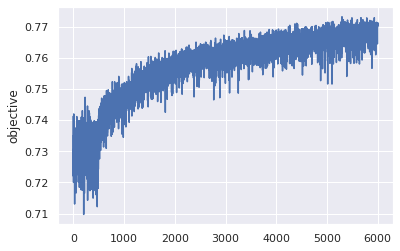

In [16]:
sns.lineplot(x=range(len(df)-1), y=df['objective'][1:])